In [3]:
# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as f
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import csv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#set seed for consistency and reproducibility
torch.manual_seed(123)
if torch.cuda.is_available:
  torch.cuda.manual_seed_all(1234)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar_data(train_files, test_file):
    # Load training data
    train_data = []
    train_labels = []
    for file in train_files:
        batch = load_cifar_batch("/content/drive/MyDrive/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/"+file)
        #print(batch)
        train_data.extend(batch[b'data'])
        train_labels += batch[b'labels']

    train_data = np.vstack(train_data)
    train_labels = np.array(train_labels)

    # Load test data
    test_batch = load_cifar_batch(test_file)
    #print(test_batch)
    test_data = test_batch[b'data']
    #print(test_data)
    test_labels = list(range(len(test_data)))

    return train_data, train_labels, test_data, test_labels

train_files = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_file = '/content/drive/MyDrive/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'

train_data, train_labels, test_data, test_labels = load_cifar_data(train_files, test_file)

train_data = train_data.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)
test_data = test_data.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)


# Split the training data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.02, random_state=42)


In [7]:
print(val_labels.size)

1000


In [8]:
from torch.utils.data import Dataset
from PIL import Image

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# transformation for train data
train_transform = transforms.Compose([
    transforms.RandomRotation(10), # Add random rotation with 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), # Add color jitter
    transforms.RandomHorizontalFlip(), #apply horizontal flipping
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # Convert the image to PIL Image format (assuming data is in the range [0, 255])
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


# Create a custom dataset instance
train_dataset = CustomDataset(train_data, train_labels, train_transform)
test_dataset = CustomDataset(test_data, test_labels, test_transform)
val_dataset = CustomDataset(val_data, val_labels, transform=test_transform)

#print(test_dataset.data)

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)

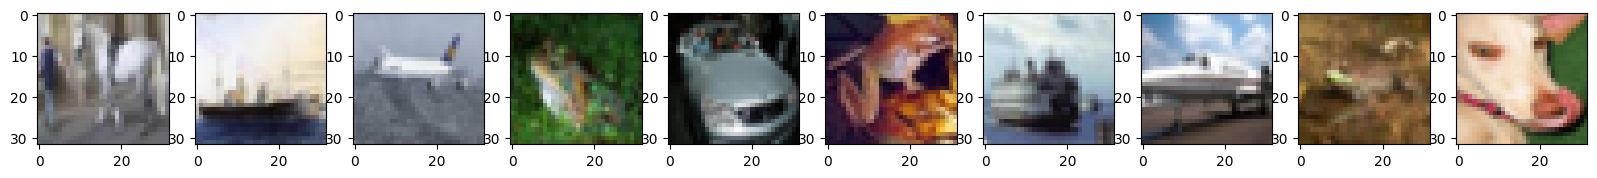

In [10]:
# Display the first 10 images and labels
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(val_dataset.data[i])
    #plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    #plt.axis('off')
plt.show()

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        #in_planes = input chanel size
        #planes = output chanel size
        #convolution later 1
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        #batch norm 1
        self.bn1 = nn.BatchNorm2d(planes)
        #convolution layer 2
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        #batch norm 2
        self.bn2 = nn.BatchNorm2d(planes)

        #skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    #forward pass of res-net
    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = f.relu(out)
        return out


In [12]:
#to edit the number of channels
channels = [32, 64, 256, 256]

In [13]:
class ResNet(nn.Module):
    def __init__(self, channels, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = channels[0]
        dropout_probability = 0.2
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.layer1 = self._make_layer(block, channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], num_blocks[3], stride=2)
        self.linear = nn.Linear(channels[3]*4*4, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_probability)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = f.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        # comment the line below to remove dropout layer
        out = self.dropout(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = f.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)

        # Apply dropout
        out = self.dropout(out)

        out = self.linear(out)
        return out

In [14]:
def ResNet18():
    return ResNet(channels, BasicBlock, [2, 2, 2, 2])

In [15]:
# Create an instance of ResNet18
model = ResNet18()
model.to(device)

# Count the number of parameters
num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters: ", num_params)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#uncomment the below line for lr scheduling
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)


Number of parameters:  4573994


In [16]:
def train_model(epoch):
  # num_batches = torch.ceil(torch.tensor(len(train_dataset)/100)).item()
  model.train()
  train_acc = 0
  epoch_loss = 0
  for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      # print(train_loader, len(train_loader))
      # Forward pass
      output = model(images)
      loss = criterion(output, labels)
      # acc = calculate_accuracy(output, labels)
      _, predicted = torch.max(output.data, 1)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # epoch_acc += acc
      train_acc += (labels == predicted).sum().item()
      epoch_loss += loss.item()


  # Validation
  model.eval()
  val_acc = 0
  val_loss = 0
  for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)
    output = model(images)
    loss = criterion(output, labels)
    _, predicted = torch.max(output.data, 1)
    val_acc += (labels == predicted).sum().item()
    val_loss += loss.item()

    # Calculate validation accuracy and loss
    val_accuracy = val_acc / len(val_dataset)
    val_loss = val_loss / len(val_loader)

  print(f'Epoch [{epoch+1}/{num_epochs}],'
          f'Train Loss: {epoch_loss / len(train_loader):.4f}, Train Acc: {train_acc / len(train_dataset)}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
  return round((train_acc / len(train_dataset))*100,2)

In [17]:
# Test the model
def model_eval():
  model.eval()
  with torch.no_grad():
      #correct = 0
      #total = 0
      labels_predicted = []
      for images, ids in test_loader:
          images = images.to(device)
          #labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          labels_predicted += predicted.tolist()

  # Save the model checkpoint
  ids = range(len(labels_predicted))
  df = pd.DataFrame({'ID': ids, 'Labels': labels_predicted})
  df.to_csv('predictions.csv', index=False)
  torch.save(model.state_dict(), 'resnet.ckpt')

In [ ]:
# Training loop
num_epochs = 75
best_acc = 0
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
  train_accuracies.append(train_model(epoch))
  #scheduler.step() #uncomment while implementing lr scheduling


model.eval()

In [ ]:
model_eval()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data (replace these with your actual data)
epochs = range(1, num_epochs+1)
# train_accuracies
# test_accuracies

# Creating a DataFrame
result_data = pd.DataFrame({
    'Epochs': epochs,
    'Training Accuracy': train_accuracies,
    'Validation Accuracy': test_accuracies
})

# # Plotting loss vs epoch
# plt.figure(figsize=(10, 5))
# sns.lineplot(data=data[['Training Loss', 'Validation Loss']], markers=True)
# plt.title('Training and Validation Loss vs Epoch')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend(['Training Loss', 'Validation Loss'])
# plt.grid(True)
# plt.show()

# Plotting accuracy vs epoch
plt.figure(figsize=(10, 5))
sns.lineplot(data=result_data[['Training Accuracy', 'Validation Accuracy']], markers=True)
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid(True)
plt.show()
